<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/notebooks/01-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a hacer análisis exploratorio de un dataset de tweets.

Es muy importante siempre investigar acerca del dataset antes de explorarlo (e.g. leer repositorios o papers asociados, etc.). ¿Quién lo recopiló? ¿Con qué propósito? ¿Cómo se recopiló? Etc...

-----------------------

Tarea: entender todo el código y responder donde dice **PREGUNTA**

## Configuración del entorno

In [ ]:
!pip install -qU datasets spacy nltk scikit-learn watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.4 which is incompatible.


In [ ]:
%reload_ext watermark

In [ ]:
%watermark -vmp datasets,spacy,nltk,sklearn,numpy,pandas,tqdm,matplotlib

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

datasets  : 3.3.2
spacy     : 3.8.4
nltk      : 3.9.1
sklearn   : 1.6.1
numpy     : 1.26.4
pandas    : 2.2.2
tqdm      : 4.67.1
matplotlib: 3.10.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Carga de datos

Vamos a cargar el dataset con la librería de Hugging Face `datasets` pero lo vamos a convertir a un DataFrame de pandas. Más adelante vamos a trabajar con `datasets` directamente.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

¿Qué pinta tiene?

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [ ]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}

In [ ]:
dataset["train"][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

In [ ]:
# Convertimos los labels a strings por comodidad
int2label = dataset["train"].features["label"].int2str
dataset = dataset.map(lambda example: {"label_str": int2label(example["label"])}, remove_columns=["label"])
dataset = dataset.rename_column("label_str", "label")

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [ ]:
dataset["train"][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 'optimism'}

In [ ]:
# Convertimos a pandas por comodidad
import pandas as pd
pd.options.display.max_colwidth = 300

dfs = {split: dataset[split].to_pandas() for split in dataset.keys()}
#del dataset

In [ ]:
dfs["train"].sample(3, random_state=33)

,text,label
448,Well my evaluation came back and i am minimally effective. Student test scores on the PARCC sunk my eval. it's time for me to quit teaching,sadness
204,@user @user whatever Sam is holding on your tee looks like it's got a droop on 😂,joy
2685,@user #rage?? The #CrookedCourt said #rage MANY times to explain away the brutal killings of #Petits by #Hayes &amp; #Komisarjevsky,anger


## Análisis exploratorio

Vamos a ir respondiendo preguntas que uno típicamente se hace al explorar un dataset como este, que luego se va a usar para alguna tarea de NLP.

### 1. ¿Cómo es la distribución de clases?

In [ ]:
for split, df in dfs.items():
    print(split)
    print(df["label"].value_counts(normalize=False))
    print()

train
label
anger       1400
sadness      855
joy          708
optimism     294
Name: count, dtype: int64

test
label
anger       558
sadness     382
joy         358
optimism    123
Name: count, dtype: int64

validation
label
anger       160
joy          97
sadness      89
optimism     28
Name: count, dtype: int64



### 2. ¿Cómo es la longitud de los textos? ¿Hay documentos anormalmente largos o cortos?

Para responder esto necesitamos una manera de contar palabras / tokens / unidades de texto. Es decir, necesitamos **tokenizar**.

In [ ]:
# A veces alcanza con contar espacios:
num_words = {}
for split, df in dfs.items():
    num_words[split] = df["text"].str.count(" ") + 1

for split, df in dfs.items():
    print(split)
    print(num_words[split].describe())
    print()

train
count    3257.000000
mean       16.314400
std         6.750513
min         1.000000
25%        11.000000
50%        17.000000
75%        22.000000
max        58.000000
Name: text, dtype: float64

test
count    1421.000000
mean       15.998593
std         6.760386
min         1.000000
25%        10.000000
50%        16.000000
75%        22.000000
max        56.000000
Name: text, dtype: float64

validation
count    374.000000
mean      15.810160
std        6.912227
min        1.000000
25%       10.000000
50%       16.000000
75%       22.000000
max       32.000000
Name: text, dtype: float64



In [ ]:
# O contar caracteres:
num_chars = {}
for split, df in dfs.items():
    num_chars[split] = df["text"].str.len()

for split, df in dfs.items():
    print(split)
    print(num_chars[split].describe())
    print()

train
count    3257.000000
mean       91.272029
std        36.536134
min         6.000000
25%        60.000000
50%        96.000000
75%       126.000000
max       160.000000
Name: text, dtype: float64

test
count    1421.000000
mean       89.832512
std        36.762850
min        10.000000
25%        60.000000
50%        93.000000
75%       124.000000
max       147.000000
Name: text, dtype: float64

validation
count    374.000000
mean      88.639037
std       38.372531
min        6.000000
25%       55.000000
50%       91.500000
75%      123.000000
max      152.000000
Name: text, dtype: float64



Otras veces nos gustaría ser más cuidados a la hora de separar en palabras, por ejemplo, en inglés podríamos separar "don't" en "do" y "n't", o "I'm" en "I" y "'m".

Para esto podemos usar tokenizadores informados por el lenguaje, como los de la librería `spacy`.

In [ ]:
# Usando spacy:
from spacy.lang.en import English

nlp = English()
tokenizer = nlp.tokenizer

example = dfs["train"]["text"].iloc[0]
tokens_example = tokenizer(example)

print(example)
print([token.text for token in tokens_example])

“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
['“', 'Worry', 'is', 'a', 'down', 'payment', 'on', 'a', 'problem', 'you', 'may', 'never', 'have', "'", '.', '\xa0', 'Joyce', 'Meyer', '.', ' ', '#', 'motivation', '#', 'leadership', '#', 'worry']


In [ ]:
# Usando tokenizer.pipe podemos correrlo para una lista de documentos:
num_tokens = {}

for split, df in dfs.items():
    generator_ = tokenizer.pipe(df["text"], batch_size=50)
    num_tokens[split] = pd.Series([len(doc) for doc in generator_])

for split, df in dfs.items():
    print(split)
    print(num_tokens[split].describe())
    print()

train
count    3257.000000
mean       19.769113
std         8.235186
min         1.000000
25%        13.000000
50%        20.000000
75%        26.000000
max        85.000000
dtype: float64

test
count    1421.000000
mean       19.581985
std         8.115873
min         1.000000
25%        13.000000
50%        20.000000
75%        26.000000
max        41.000000
dtype: float64

validation
count    374.000000
mean      19.631016
std        8.719194
min        1.000000
25%       13.000000
50%       20.000000
75%       27.000000
max       41.000000
dtype: float64



Si estamos trabajando con tweets, donde los emojis y los hashtags son importantes, quizás sea mejor usar un tokenizador especializado en tweets:

In [ ]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
# strip_handles=False: elimina los @user
# reduce_len=True: reduce los caracteres repetidos a 3 e.g. "aaaaaa" -> "aaa"

example = dfs["train"]["text"].iloc[0]
tokens_example = tokenizer.tokenize(example)

print(example)
print(tokens_example)


“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
['“', 'Worry', 'is', 'a', 'down', 'payment', 'on', 'a', 'problem', 'you', 'may', 'never', 'have', "'", '.', 'Joyce', 'Meyer', '.', '#motivation', '#leadership', '#worry']


**PREGUNTA**: ¿Por qué motivo querríamos usar `reduce_len=True`?

In [ ]:
# Veamos cuáles son los ejemplos más largos y más cortos:
import textwrap

tokenizer = TweetTokenizer(strip_handles=False, reduce_len=False)

for split, df in dfs.items():
    df["num_tokens"] = df["text"].apply(lambda x: len(tokenizer.tokenize(x)))

for split, df in dfs.items():
    short_texts = df.sort_values("num_tokens", ascending=True).head(3)["text"].values
    long_texts = df.sort_values("num_tokens", ascending=False).head(3)["text"].values
    print("##", split)
    print("# Short:")
    for text in short_texts:
        print("- \t", textwrap.fill(text, 120))
    print("# Long:")
    for text in long_texts:
        print("- \t", textwrap.fill(text, 120))
    print()


## train
# Short:
- 	 fuming
- 	 revenge
- 	 @user bully
# Long:
- 	 @user Start w/ the 3 songs in Blue Neighborhood\n1) Wild\n2)Fools\n3)Talk Me down 😭😭for #Wesper\nAlso,\n4)Too Good.
#serious kaz/inej feelz
- 	 Lament a \nsaddened heart,\nso far &amp; \nyet so near,\nthe years so\ntough &amp; scarred,\nthis lonesome\nroad,\nstill
feared! #depression \n\n#poetry #poem
- 	 I am #real #sjw, I will not let #america down\nI have found us, now go and get us\nI let it out and I let it in\nI #rage
I #lol\n@SergioSarzedo

## test
# Short:
- 	 discouraged
- 	 Goodevening 😆
- 	 i'm nervous
# Long:
- 	 'I have a problem with authority.'\n\n'Oh, you mean you hate being told what to do?'\n\n'No. Authority figures just
terrify me.'\n\n#SocialAnxiety
- 	 “I am very sad and I feel more miserable than I can say, and I do not know how far I’ve come. I do not know what to do
or what to think.”
- 	 Poetry of love ❤️ #.I love you from my heart # I love you from my soul # I love you real # you are in my al

In [ ]:
dfs["train"].sort_values("num_tokens", ascending=False).head(3)

,text,label,num_tokens
1798,"@user Start w/ the 3 songs in Blue Neighborhood\n1) Wild\n2)Fools\n3)Talk Me down 😭😭for #Wesper\nAlso,\n4)Too Good. #serious kaz/inej feelz",joy,42
2429,"Lament a \nsaddened heart,\nso far &amp; \nyet so near,\nthe years so\ntough &amp; scarred,\nthis lonesome\nroad,\nstill feared! #depression \n\n#poetry #poem",sadness,41
479,"I am #real #sjw, I will not let #america down\nI have found us, now go and get us\nI let it out and I let it in\nI #rage I #lol\n@SergioSarzedo",anger,40


### 3. ¿Hay caracteres raros o inesperados?

In [ ]:
# Por ejemplo, caracteres html como &amp; se pueden convertir a su forma original:

mask = dfs["train"]["text"].str.contains("&amp;")
print(dfs["train"][mask].shape)

(140, 3)


In [ ]:
import html

example = dfs["train"][mask]["text"].iloc[0]

print(example)
print(html.unescape(example))

#NewYork: Several #Baloch &amp; Indian activists hold demonstrations outside @user headquarters demanding Pak to stop exporting #terror into India
#NewYork: Several #Baloch & Indian activists hold demonstrations outside @user headquarters demanding Pak to stop exporting #terror into India


In [ ]:
# O caracteres whitespace no identificados como tales:
mask = dfs["train"]["text"].str.contains("\\\\n") # tienen "\n" literales
print(dfs["train"][mask].shape)

example = dfs["train"][mask]["text"].iloc[1]
print(example)
print(example.replace("\\n", "\n"))

(157, 3)
her; i want a playful relationship\nme; *kicks her off the couch*
her; i want a playful relationship
me; *kicks her off the couch*


### 4. ¿Hay documentos duplicados?


In [ ]:
# buscar duplicados:
for split, df in dfs.items():
    print(split)
    print(df["text"].duplicated().sum())
    print()

train
25

test
0

validation
0



In [ ]:
mask = dfs["train"]["text"].duplicated(keep=False)
dfs["train"][mask].sort_values("text")

,text,label,num_tokens
176,Watch this amazing live.ly broadcast by @user #musically,joy,8
2329,Watch this amazing live.ly broadcast by @user #musically,joy,8
2113,Watch this amazing live.ly broadcast by @user #musically,joy,8
1538,Watch this amazing live.ly broadcast by @user #musically,joy,8
1282,Watch this amazing live.ly broadcast by @user #musically,joy,8
1251,Watch this amazing live.ly broadcast by @user #musically,joy,8
1056,Watch this amazing live.ly broadcast by @user #musically,joy,8
1254,Watch this amazing live.ly broadcast by @user #musically,joy,8
447,Watch this amazing live.ly broadcast by @user #musically,joy,8
271,Watch this amazing live.ly broadcast by @user #musically,joy,8


**PREGUNTA**: por qué motivo podrían estar duplicados estos tweets?

### 4. ¿Hay documentos raros?

"raro" es un término subjetivo, pero podríamos pensar en documentos que son muy cortos, muy largos, con cosas inesperadas, etc. O si hay una variable respuesta, documentos con errores de anotación.

Una manera sencilla y bastante general de detectar documentos raros en tareas de clasificación es corriendo un modelo sencillo y viendo los documentos que más pérdida generan, i.e. los que el modelo no puede clasificar bien.

Vamos a usar una regresión logística para esto. Más adelante vamos a analizar esto con much más detalle!

In [ ]:
print(dfs["train"].shape)

(3257, 3)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(max_features=150)
clf = LogisticRegression(max_iter=1000)
class2int = {label: i for i, label in enumerate(dfs["train"]["label"].unique())}
int2class = {i: label for label, i in class2int.items()}

X_train = vectorizer.fit_transform(dfs["train"]["text"])
y_train = dfs["train"]["label"].map(class2int)

clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**PREGUNTA** qué representa cada fila y cada columna de `X_train`?

In [ ]:
# Ejemplos con mayor pérdida (medida como -log(probabilidad_clase_correcta)):
import numpy as np

y_pred_proba = clf.predict_proba(X_train)
loss = -np.log(y_pred_proba[range(len(y_train)), y_train])
y_pred = clf.predict(X_train)

dfs["train"]["pred"] = [int2class[i] for i in y_pred]
dfs["train"]["loss"] = loss

dfs["train"].sort_values("loss", ascending=False).head(8)

,text,label,num_tokens,pred,loss
726,While we focus on issue of #IPCA @user Indulges in #intimidation @user @user @user @user #StopCruelty,optimism,16,anger,4.601743
1300,@user @user looks like a book shaped like a gun to me #optimism #itsagunalright,optimism,14,anger,4.309918
2852,"@user I agree. Btw, have u seen Ep22, Granger, O? That was the episode when I knew Anna was coming back, the conversation at start.",optimism,32,sadness,4.045089
183,I told my chiropractor 'I'm here for a good time not a long time' when he questioned my habits and yet again I have unnerved a doctor,optimism,29,sadness,3.920117
960,If I was a ghost I'd haunt people by giving them cramps in both of their legs when they do cardio 😈😈😈 #Mwahaha,joy,25,anger,3.888243
330,@user I was like that when I started college. It was horrific but it probably will get better. Don't give up yet,optimism,24,anger,3.795332
3180,one of the main things im doing w/ 13c is filling in the void of my empty bitter heart by making everything how i wanted it to be growing up,optimism,31,anger,3.748906
1130,Will do fine on the mat tonight with or without sleep. theres no worry for that on this side of the water,optimism,23,anger,3.664447


### 5. ¿Cómo es la distribución de palabras?

Para esto es fundamental (1) preprocesar el texto y (2) tokenizarlo. La manera en la que hagamos esto depende directamente del análisis que queramos hacer.

Cosas a definir: ¿queremos diferenciar mayúsculas y minúsculas? ¿Queremos eliminar _stopwords_? ¿Queremos eliminar puntuación? ¿Queremos lematizar o hacer stemming?

In [ ]:
# Empecemos usando el tokenizador de tweets de nltk.
# Para cada documento queremos un vector del tamaño del vocabulario con la
# cantidad de veces que aparece cada palabra.
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(strip_handles=False, reduce_len=True)
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)

X_train = vectorizer.fit_transform(dfs["train"]["text"])
df_vocab_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

print(df_vocab_train.shape)
df_vocab_train.head()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3257, 9435)


,!,#,#10golds24,#12years,#2016,#20likes,#22september2004,#2hour,#3amdeadtime,#48,...,🙏🏾,🛂,🤐,🤓,🤔,🤖,🤗,🦄,🧀,󾌴
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**PREGUNTA**: ¿cuántas palabras hay en el vocabulario?

In [ ]:
# palabras más y menos frecuentes:
vocab_freq = df_vocab_train.sum().sort_values(ascending=False)

print(vocab_freq.head(10))
print(vocab_freq.tail(10))

@user    2019
.        1977
the      1515
to       1207
i        1168
,        1089
a        1054
and       885
!         762
is        736
dtype: int64
dried        1
drew         1
dressed      1
dreary       1
dreamt       1
dreamboys    1
drank        1
drama        1
drake        1
󾌴            1
dtype: int64


In [ ]:
# Eliminando stopwords (palabras frecuentes con poca carga semántica),
# mayúsculas, mentions y punctuación (pero sin eliminar hashtags!):
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
import string

stop_words = stopwords.words("english")
print(stop_words[:5])

print(string.punctuation)

def preprocess_text(text: str) -> str:
    """Limpia antes de tokenizar."""
    text = text.lower()
    text = text.replace("\\\\n", " ")
    text = html.unescape(text)
    exclude = {'#', "'", "@"}
    text = ''.join(char for char in text if char not in string.punctuation or char in exclude)
    return text

example = "I'm a #tweet with @user and a link: https://t.co/1234"
print(example)
print(preprocess_text(example))

['a', 'about', 'above', 'after', 'again']
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
I'm a #tweet with @user and a link: https://t.co/1234
i'm a #tweet with @user and a link httpstco1234


In [ ]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
vectorizer = CountVectorizer(
    tokenizer=tokenizer.tokenize, stop_words=stop_words, preprocessor=preprocess_text
)

X_train = vectorizer.fit_transform(dfs["train"]["text"])
df_vocab_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())

print(df_vocab_train.shape)
df_vocab_train.head()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3257, 9312)


,#,#10golds24,#12years,#2016,#20likes,#22september2004,#2hour,#3amdeadtime,#48,#500aday,...,🙏🏾,🛂,🤐,🤓,🤔,🤖,🤗,🦄,🧀,󾌴
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vocab_freq = df_vocab_train.sum().sort_values(ascending=False)
print(vocab_freq.head(20))

'         397
like      222
get       168
people    139
one       114
know       99
think      96
would      89
u          88
can't      88
really     87
go         84
day        84
time       84
got        83
even       83
back       80
love       77
want       77
😂          73
dtype: int64


**PREGUNTA**: ¿Cómo tratarían las tildes en español?

In [ ]:
# Palabras más populares de cada clase:
df_data = df_vocab_train.copy()
df_data["CLASE"] = dfs["train"]["label"]
# pusimos CLASE para que no se confunda con una palabra del vocabulario
df_data = df_data.groupby("CLASE").sum().T
df_data.sort_values("joy", ascending=False).head(10)

CLASE,anger,joy,optimism,sadness
',183,80,46,88
love,13,47,8,9
😂,16,41,1,15
watch,13,38,3,7
like,113,37,14,58
day,16,36,4,28
amazing,1,35,0,1
lively,0,34,0,2
one,44,27,9,34
#musically,0,27,0,0


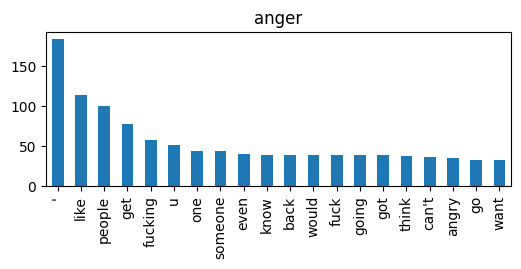

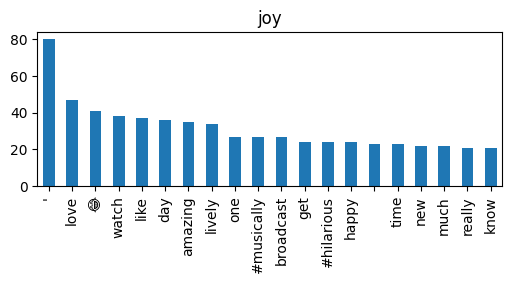

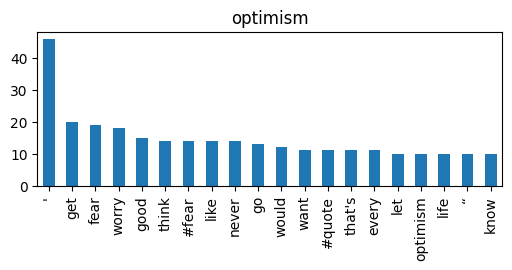

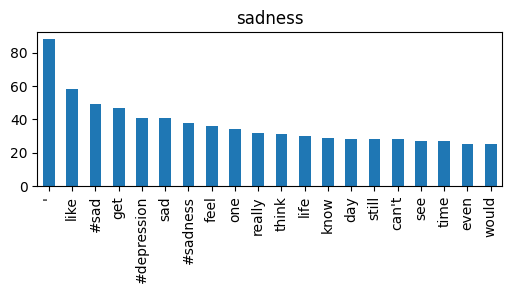

In [ ]:
# visualizamos las palabras más populares de cada clase:
import matplotlib.pyplot as plt

labels = list(df_data.columns)
n = 20

for label in labels:
    df_plot = df_data[label].sort_values(ascending=False).head(n)
    df_plot.plot(kind="bar", title=label, figsize=(6, 2))
    plt.show()

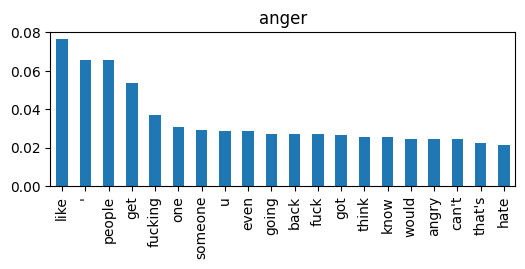

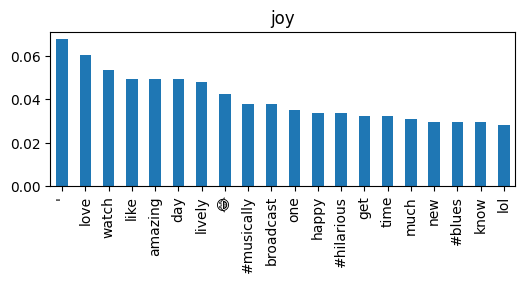

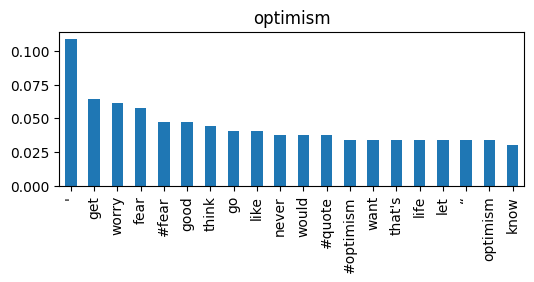

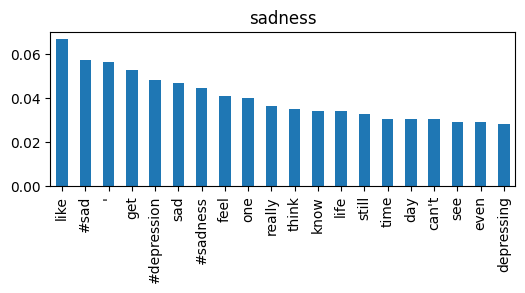

In [ ]:
# Ahora, % de documentos en los que aparece cada palabra, por clase:
df_data = df_vocab_train.astype(bool).astype(int).copy()
df_data["CLASE"] = dfs["train"]["label"]
df_data = df_data.groupby("CLASE").mean().T

for label in labels:
    df_plot = df_data[label].sort_values(ascending=False).head(n)
    df_plot.plot(kind="bar", title=label, figsize=(6, 2))
    plt.show()

In [ ]:
# Esto se puede seguir mejorando...
# Más adelante vamos a ver cómo encontrar las palabras más _discriminativas_ entre clases

**PREGUNTA**: ¿Cuándo puede ser distinto analizar la frecuencia y el % de documentos en los que aparece una palabra?

**PREGUNTA**: ¿Cómo mejorar visualmente estos gráficos?

### 6. Stemming, lematización, y regex: ejemplos de uso

- **Stemming**: Reducción de palabras a su raíz base.
- **Lematización**: Transformación de palabras a su forma canónica.
- **Regex**: expresiones regulares para identificar patrones en el texto.

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer

nlp = English()
tokenizer = nlp.tokenizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

examples = [
    "Speaking words of wisdom, let it be.",
    "His palms are sweaty, knees weak, arms are heavy.",
    "The mice were running through the house, searching for food.",
]

for example in examples:
    tokens = [token.text for token in tokenizer(example)]
    stemmed = [stemmer.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    print("Stemming", stemmed)
    print("Lemmatized", lemmatized)
    print()

# TODO regex_words = re.findall(r'\b\w+mente\b', texto)

Stemming ['speak', 'word', 'of', 'wisdom', ',', 'let', 'it', 'be', '.']
Lemmatized ['Speaking', 'word', 'of', 'wisdom', ',', 'let', 'it', 'be', '.']

Stemming ['hi', 'palm', 'are', 'sweati', ',', 'knee', 'weak', ',', 'arm', 'are', 'heavi', '.']
Lemmatized ['His', 'palm', 'are', 'sweaty', ',', 'knee', 'weak', ',', 'arm', 'are', 'heavy', '.']

Stemming ['the', 'mice', 'were', 'run', 'through', 'the', 'hous', ',', 'search', 'for', 'food', '.']
Lemmatized ['The', 'mouse', 'were', 'running', 'through', 'the', 'house', ',', 'searching', 'for', 'food', '.']



**PREGUNTA** ¿En qué casos serviría usar stemming / lematización para un problema de clasificación? Ante la duda, ¿cómo puedo definir si sirve o no?

Algunas expresiones regulares comunes:

* "." : Matchea cualquier caracter excepto '\n'
* "^" y "$": Matchean el comienzo y el final de un string
* "[]": Matchea el set de caracteres que se encuentren dentro de los corchetes (r"l[ao]s" machea "las" y "los")
* \d: Matchea digitos; equivalente a [0-9].
* \D: Matchea caracteres que NO sean digitos; equivalente a [^0-9].
* \s: Matchea espacios en blanco; equivalente a [ \t\n\r\f\v].
* \S: Matchea espacios que NO esten en blanco; equivalente a [^ \t\n\r\f\v].
* \w: Matchea caracteres alfanuméricos; equivalente a [a-zA-Z0-9_].
* \W: Matchea caracteres que NO sean alfanuméricos; equivalente a[^a-zA-Z0-9_].
* a|b: Matchea "a" o "b"

Para repeticiones de patrones:
* "+": Matchea 1 o mas ocurrencias
* "*": Matchea 0 o mas ocurrencias
* "?": Matchea 0 o 1 ocurrencia
* "{n, m}": Matchea entre n y m ocurrencias
* "\\": Permite matchear caracteres especiales

Para más info ver: https://docs.python.org/3.1/library/re.html#re-syntax

In [8]:
# Algunos ejemplos:
import re

texto = "las cámaras y los libros sobre laos de luis alberto"
patron = r"l[ao]s"
resultados = re.findall(patron, texto)
print(texto)
print(patron)
print(resultados)
print()

texto = "Mi número es 12345 y tu número es 67890."
patron = r"\d+"
resultados = re.findall(patron, texto)
print(texto)
print(patron)
print(resultados)
print()

texto = "123 un pasito palante maría, 123 un pasito patrás"
patron = r"\D+"
resultados = re.findall(patron, texto)
print(texto)
print(patron)
print(resultados)
print()

# Buscamos precios compuestos por 2 o 3 dígitos, opcionalmente seguidos de un espacio y la palabra "USD" o "usd"
texto = "El precio es 100USD, o tal vez 50 USD o 250usd."
patron = r"(\d{2,3})\s?[USD|usd]"
resultados = re.findall(patron, texto)
print(texto)
print(patron)
print(resultados)
print()

las cámaras y los libros sobre laos de luis alberto
l[ao]s
['las', 'los']

Mi número es 12345 y tu número es 67890.
\d+
['12345', '67890']

123 un pasito palante maría, 123 un pasito patrás
\D+
[' un pasito palante maría, ', ' un pasito patrás']

El precio es 100USD, o tal vez 50 USD o 250usd.
(\d{2,3})\s?[USD|usd]
['100', '50', '250']

